**Input:** Text

**Output:** Sentiment Label [0, 1, 2]

- **0:** Negative Sentiment
- **1:** Neutral Sentiment
- **2:** Positive Sentiment

In [4]:
pip install pythainlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 46.7 MB/s eta 0:00:00


In [5]:
import re
import string
import numpy as np
import pandas as pd

from pythainlp import word_tokenize
from pythainlp.util import normalize
from pythainlp.corpus import thai_stopwords
from pythainlp import word_tokenize

from keras import regularizers
from keras import backend as K
from keras.models import Sequential
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, SpatialDropout1D

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


In [6]:
train_df = pd.read_csv('train.csv')


### Preprocess

In [7]:
train_df['length'] = train_df['texts'].apply(word_tokenize).apply(len)


In [8]:
train_df = train_df[train_df['length'] < train_df['length'].quantile(0.95)]

In [9]:
train_df = train_df[train_df['length'] >= train_df['length'].quantile(0.05)]

In [10]:
train_df.category.value_counts()

neu    11886
neg     5984
pos     4100
Name: category, dtype: int64

In [11]:
class_names = np.unique(train_df.category).tolist()
class_names

['neg', 'neu', 'pos']

In [12]:
train_df

,category,texts,length
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,13
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค,9
4,neu,สวัสดีวันพุธ แนน อะไรนะ,8
5,neu,ก้อนขอบพระคุณมากๆนะคร้าบ ที่มาหาก้อนและชมเชยกา...,23
7,neu,ปากแดงกินฟรีค่ะ 😬😬,7
...,...,...,...
23540,neg,แม่งควายล้วนนน,5
23541,neg,ดอยสุเทพน้องง ไปหมดแล้วววว #pm25,13
23542,neg,ค่าชุดอาจจะแพงกว่าส่วนลด,6
23543,neu,รัฐต้องการแค่ภาษีครับ,5


In [13]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### **Preprocess**


#### Tokenizer
Before training, I converted text to numbers because models learn only from numerical. Breaking down long sentences into individual words   simplify the learning process of the model


for example

In [14]:
train_df['texts'][0]

'ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ'

In [15]:
word_tokenize(train_df['texts'][0])

['ประเทศ',
 'เรา',
 'ผลิต',
 'และ',
 'ส่งออก',
 'ยาสูบ',
 'เยอะ',
 'สุด',
 'ใน',
 'โลก',
 'จิง',
 'ป่าว',
 'คับ']

In [16]:
# Tokenize using pythainlp
train_df['tokenized_texts'] = train_df['texts'].apply(word_tokenize)

# Create a dictionary mapping words to unique integer indices
word_index = {}
for words_list in train_df['tokenized_texts']:
    for word in words_list:
        if word not in word_index:
            word_index[word] = len(word_index) + 1  # Start indexing from 1

# Convert the text sequences to integer sequences based on the word_index
train_df['sequences'] = train_df['tokenized_texts'].apply(lambda words_list: [word_index[word] for word in words_list])

# Get the maximum sequence length
max_length = max(len(sequence) for sequence in train_df['sequences'])
print("Maximum Sequence Length:", max_length)

Maximum Sequence Length: 99


### Padding sequence

<li> help us receive input text sentences with different range for training with neural network that have to fixed size input by multiplying input method like zero padding


for example

Original Sequence 1: `[1, 2, 3]` | Padded Sequence 1: `[0, 1, 2, 3]`

Original Sequence 2: `[4, 5]` | Padded Sequence 2: `[0, 0, 4, 5]`



In [17]:
# Padding sequences
X = pad_sequences(train_df['sequences'], maxlen=max_length)

For the process of assigning numerical labels to each unique category:

1. Initialize a `LabelEncoder` instance.
2. Apply `fit_transform` assigns numerical labels to each category.


In [18]:
# assign numerical labels to each unique category
le = LabelEncoder()
__y = le.fit_transform(train_df['category'])
_y = __y.copy()

For the process of changing numerical labels to one-hot vectors:

1. Utilize `to_categorical` to convert numerical labels to one-hot encoded vectors.
2. For instance:
   - 'positive' is represented as [0, 0, 1]
   - 'negative' is represented as [1, 0, 0]
   - 'neutral' is represented as [0, 1, 0]

In [19]:
y = to_categorical(_y)

# Vocabulary size
vocab_size = len(word_index) + 1
print("Vocabulary size:", vocab_size)


Vocabulary size: 23825


In [20]:
train_df['tokenized_texts']

0        [ประเทศ, เรา, ผลิต, และ, ส่งออก, ยาสูบ, เยอะ, ...
2            [อิ, เหี้ย, ออม, ทำ, กู, อยาก, กิน, เอ็ม, เค]
4                  [สวัสดี, วัน, พุธ,  , แนน,  , อะไร, นะ]
5        [ก้อน, ขอบพระคุณ, มาก, ๆ, นะ, คร้าบ,  , ที่, ม...
7                         [ปาก, แดง, กิน, ฟรี, ค่ะ,  , 😬😬]
                               ...                        
23540                             [แม่, ง, ควาย, ล้วน, นน]
23541    [ดอย, สุเทพ, น้อง, ง,  , ไป, หมด, แล้ว, ววว,  ...
23542                 [ค่า, ชุด, อาจจะ, แพง, กว่า, ส่วนลด]
23543                      [รัฐ, ต้องการ, แค่, ภาษี, ครับ]
23544    [™,  , ได้, พัฒนา, ระบบ, เข้าสู่, รุ่น, ที่สอง...
Name: tokenized_texts, Length: 21970, dtype: object

### "LSTM" Model

Reason why picking up lstm

- LSTM suitable for sequential data, like sentiment analysis "LSTM is designed to capture long range dependency"

- LSTM handling vanishing gradient; memory cell, forget gate, residual connection to help the network remember the previous sentences and forgot unneccessary input and skip connection to prevent vanishing gradient when sentences is long.

- Memory cell, LSTM can store and retrieve information over long periods so it will allow to remember contextual information

How's LSTM work

1. Input Sequences: the input sequences consists of sequence of words. Each words represent as a vector

2. Sequence processing: LSTM process the input one element at a time so it can capture information from earlier parts of the sentences

3. Memory Cells: select remember or forget information over long sequences

4. Gates: LSTM gate control the information in and out
    Input Gate: Decides which information to add to the memory cell.
    Forget Gate: Decides which information to discard from the memory cell.
    Output Gate: Decides what to output based on the current input and the memory cell's content.
5. Backpropagation Through Time
    It propagates the error back through the entire sequence, updating the weights at each time step to improve the model's performance.

In [34]:
initial_learning_rate = 1e-3
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9
)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0, return_sequences=True)),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(3, activation='softmax')
])
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc',f1_m,precision_m, recall_m])


In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 99, 128)           3049600   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 99, 128)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_2 (Bidirecti  (None, 99, 256)           263168    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                      

### Training

#### Class Weight
- Using class weights to address class imbalance in the dataset ensures that the model gives higher weight to minority classes, preventing them from being overshadowed by the majority class.


In [36]:
early_stopping = EarlyStopping(monitor='val_f1_m', patience=10, restore_best_weights=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(_y),  # numerical
                                        y = _y # numerical
                                    )
class_weights_dict = dict(zip(np.unique(_y), class_weights))

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping], class_weight=class_weights_dict)


Epoch 1/100
550/550 [==============================] - 45s 64ms/step - loss: 0.8994 - acc: 0.5565 - f1_m: 0.4927 - precision_m: 0.6008 - recall_m: 0.4222 - val_loss: 0.7713 - val_acc: 0.6716 - val_f1_m: 0.6131 - val_precision_m: 0.7140 - val_recall_m: 0.5397
Epoch 2/100
550/550 [==============================] - 19s 34ms/step - loss: 0.6433 - acc: 0.7037 - f1_m: 0.6893 - precision_m: 0.7329 - recall_m: 0.6518 - val_loss: 0.7773 - val_acc: 0.6702 - val_f1_m: 0.6593 - val_precision_m: 0.6973 - val_recall_m: 0.6264
Epoch 3/100
550/550 [==============================] - 16s 30ms/step - loss: 0.4836 - acc: 0.7907 - f1_m: 0.7867 - precision_m: 0.8082 - recall_m: 0.7668 - val_loss: 0.8347 - val_acc: 0.6800 - val_f1_m: 0.6719 - val_precision_m: 0.6954 - val_recall_m: 0.6505
Epoch 4/100
550/550 [==============================] - 16s 28ms/step - loss: 0.3820 - acc: 0.8310 - f1_m: 0.8299 - precision_m: 0.8433 - recall_m: 0.8174 - val_loss: 0.9514 - val_acc: 0.6600 - val_f1_m: 0.6592 - val_precisi

#### Evaluation

- **Evaluation Summarization:**
  - Due to the inherent imbalance in my dataset, the focus of the evaluation is on key metrics including precision, F1-score, and recall.
    - Precision: Measuring the accuracy of positive predictions.(How well model predict)
    - F1-score: Balancing precision and recall, particularly important in imbalanced datasets.
    - Recall: Capturing the ability to identify all relevant instances, especially vital for minority classes.


In [37]:
score = model.evaluate(X_val, y_val, verbose=1, batch_size=32)


138/138 [==============================] - 1s 9ms/step - loss: 1.1718 - acc: 0.6131 - f1_m: 0.6114 - precision_m: 0.6171 - recall_m: 0.6060


In [38]:
test_df = pd.read_csv('test.csv')

In [39]:
test_df['tokenized_texts'] = test_df['texts'].apply(word_tokenize)

# Convert the text sequences to integer sequences based on the existing word_index
test_df['sequences'] = test_df['tokenized_texts'].apply(lambda words_list: [word_index.get(word, 0) for word in words_list])

# Padding sequences
X_test = pad_sequences(test_df['sequences'], maxlen=max_length)

test_labels = le.transform(test_df['category'])
y_test = to_categorical(test_labels)


In [40]:
predictions = model.predict(X_test)

predicted_labels = np.argmax(predictions, axis=1)

84/84 [==============================] - 2s 9ms/step


In [41]:
y_test_original = np.argmax(y_test, axis=1)


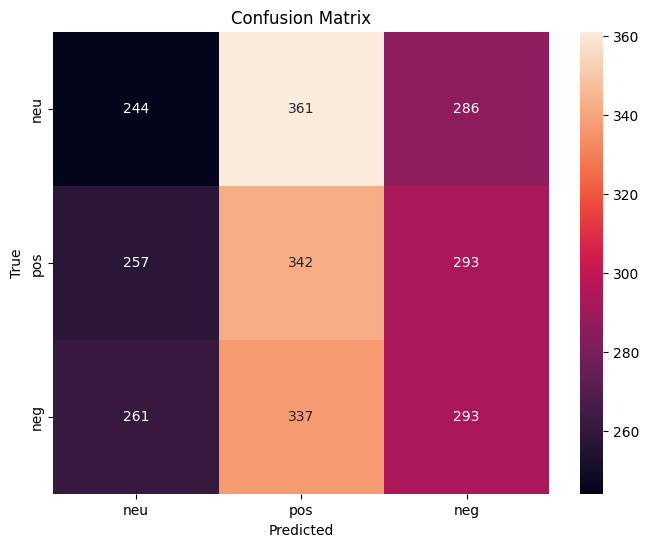

In [42]:
# Evaluate classification report
classification_report(y_test_original, predicted_labels)

conf_matrix = confusion_matrix(y_test_original, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['neu', 'pos', 'neg'], yticklabels=['neu', 'pos', 'neg'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Performance evaluation

<li> Check for the model predict wrong classes

In [43]:
incorrect_indices = np.where(predicted_labels != y_test_original)[0]

for index in incorrect_indices:
    print("Index:", index)
    print("Predicted Probabilities:", np.max(predictions[index], axis=0))
    print("Predicted Class:", predicted_labels[index])
    print("True Class:", y_test_original[index])
    print("Text:", test_df['texts'].iloc[index])
    print("\n")


Streaming output truncated to the last 5000 lines.


Index: 1566
Predicted Probabilities: 0.5987743
Predicted Class: 2
True Class: 1
Text: เลี้ยงเลย


Index: 1568
Predicted Probabilities: 0.83623266
Predicted Class: 1
True Class: 0
Text: อยากทำงานกับงานเบียร์ลีโอ


Index: 1569
Predicted Probabilities: 0.86510116
Predicted Class: 2
True Class: 1
Text: พรุ่งนี้มะ ฉลองปีใหม่กัน


Index: 1573
Predicted Probabilities: 0.9834601
Predicted Class: 1
True Class: 2
Text: เจอ Case Study หลายเคสแล้วนะครับพี่ก้อน ตั้งแต่เตาปิ้งสีดำละ.... ทำไมไม่มีทีมฝ่ายทำวิจัย-ควบคุม-ดูแล ที่เด็ดขาด ที่คมกว่านี้ครับ? เป็นผมนี่ไล่ออกยกเซ็ตเลยนะฮะ... ยึดเสากระโดงเรือไว้ให้แน่นนะครับ รักษาคุณภาพ-มาตรฐาน-ความมั่นใจของลูกค้าให้อยู่ครับ


Index: 1574
Predicted Probabilities: 0.9493751
Predicted Class: 2
True Class: 0
Text: กินกะเพราราดข้าวไปก่อนน่ะ


Index: 1576
Predicted Probabilities: 0.9979359
Predicted Class: 0
True Class: 2
Text: เน็ตตกช้ามาก youtube ยังโหลดไม่อยากจะไป Wifi เชื่อมอยู่4คนในบ้านก็เล่นไม่ค่อยได้ช้ามาก

### Most wrongs predicted classes

  1. Class 1, which represents neutral sentiment, is the most misclassified.
     - This may be due to a higher representation of the neutral class in the dataset.
  2. The neutral class is particularly challenging to determine accurately.


In [44]:
from collections import Counter

misclassified_classes_counter = Counter(y_test_original[incorrect_indices])

# Find the most frequently misclassified class
most_wrong_class, misclassification_count = misclassified_classes_counter.most_common(1)[0]

for predicted_class, misclassification_count in misclassified_classes_counter.items():
    print(f"Predicted Class: {predicted_class}, Misclassification Count: {misclassification_count}")

Predicted Class: 1, Misclassification Count: 550
Predicted Class: 0, Misclassification Count: 647
Predicted Class: 2, Misclassification Count: 598


### Test model evaluation

In [45]:
input_text = "สวัสดีวันนี้วันพฤหัสบดี วันดีๆ"


In [46]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 22ms/step
Input Text: สวัสดีวันนี้วันพฤหัสบดี วันดีๆ
Tokenized Input Sequence: ['สวัสดี', 'วันนี้', 'วัน', 'พฤหัสบดี', ' ', 'วันดี', 'ๆ']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 2
Predicted Probabilities: 0.6419948


In [49]:
input_text = "เมื่อไหร่จะวันศุกร์ ขี้เกียจทำงานน"


In [50]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 32ms/step
Input Text: เมื่อไหร่จะวันศุกร์ ขี้เกียจทำงานน
Tokenized Input Sequence: ['เมื่อไหร่', 'จะ', 'วัน', 'ศุกร์', ' ', 'ขี้เกียจ', 'ทำงาน', 'น']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 1
Predicted Probabilities: 0.57714427


In [51]:
input_text = "อยากกินขนม"


In [52]:
input_sequence = word_tokenize(input_text)

input_indices = [word_index[word] for word in input_sequence if word in word_index]

# Pad the sequence
padded_input = pad_sequences([input_indices], maxlen=max_length, padding='post')  # Assuming 'post' padding

# Make predictions
predicted_probabilities = model.predict(padded_input)

predicted_label = np.argmax(predicted_probabilities, axis=1)[0]

predicted_category = predicted_label

print("Input Text:", input_text)
print("Tokenized Input Sequence:", input_sequence)
print(f"Predicted Category, the ground truth label is {np.unique(train_df.category)}:", predicted_category) # class 2 is positve
print("Predicted Probabilities:", np.max(predicted_probabilities))

1/1 [==============================] - 0s 36ms/step
Input Text: อยากกินขนม
Tokenized Input Sequence: ['อยาก', 'กิน', 'ขนม']
Predicted Category, the ground truth label is ['neg' 'neu' 'pos']: 1
Predicted Probabilities: 0.8049069


### Conclusion

The model shows signs of overfitting due to data ambiguity. To address this, I've adjusted metrics and explored LSTM enhancements, including dropout, early stopping, and regularization. Future plans involve l
everaging pre-trained models when resources allow, along with a focus on feature engineering and data augmentation.